In [1]:
%matplotlib inline

import csv
import os
import requests
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime
from requests import get
from urllib.request import urlopen

sns.set(color_codes=True)

In [2]:
os.getcwd()

'/Users/Dhyan/Capstone_A/QTW_Case4'

# Introduction

The Credit Union Cherry Blossom Ten Mile Run is an annual run held in Washington, D.C. that brings together credit unions from across the country with a shared vision of fund raising and helping children. The proceeds from donations, registration fees, and merchandise sales from the event support Children’s Hospitals that belong to the non-profit Children's Miracle Network.

Since the innuagural run in 1973, hundreds of thousands of runners from around the world have participated in the event. The registration of each runners name, age, hometown, and race times provide an enormous trove of information regarding potential trends in the age and performance of runners over the years. The organizations website http://www.cherryblossom.org/ provides records of this data going back to 1999. This analysis will use web scraping to collect data from the website, inspect and clean the data, convert the data into a clean data frame, conduct exploratory data analysis and determine if ...        

    

# Data
Data for this analysis was taken from the Credit Union Cherry Blossom Ten Mile Run sites searcheable results web page using the URL http://www.cballtimeresults.org/performances?division=Overall+Women&page=1&section=10M&sex=W&utf8=%E2%9C%93&year=1999 as our initial reference for our web scraping function.

![title](CherryBlossom10M.png)

Each page yielded only 20 runners and the number of female runners per year varied from 2,166 to 11,042, however from page to page the URL remained consistant making it relatively simple to iteratively cycle through the **page=** and **year=** variables of the URL. After an examination of the page source it was determined that the values: *"Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", and "Hometown"* could be obtained for each runner. A CSV file was the created with the appropriate headers to store the scraped data.

In [109]:
#create outputfile
outputFile = "CherryBlossomWomens10M.csv"

#create headers
file = open("CherryBlossomWomens10M.csv", "w",encoding='utf8' )
writer = csv.DictWriter(
    file, fieldnames=["Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", "Hometown", 'State','Blank1','Blank2',])
writer.writeheader()
file.close()

In [108]:
#split the marathon url into two parts to format page number and year
websiteURLpart1 = "http://www.cballtimeresults.org/performances?division=Overall+Women&page="
websiteURLpart2 = "&section=10M&sex=W&utf8=%E2%9C%93&year="

Through an examination of the page source it was determined that 'tr class='print-link-color' indicated entries for a new runner and two functions where created. The first function would update the URL **page=** and **year=** and the second function would parse the URL calling the first function to update the URL when no more 'tr class='print-link-color' entries where found on the page and update the year when the end page was reached.   

In [110]:
#create url function to format the url that is then passed to requests to get the html page
def createURL(url1, url2, pageNum, year):
    return(url1 + str(pageNum) + url2 + str(year))

#create parsing function that uses createURL to iterate through pages
def getRunners(url1, url2):
    year = 1999
    #iterate through all years from 1999 to 2018
    while(year < 2019):
        pageNum = 1
        morePages = True
        #iterate through all pages in each year
        while(morePages):
            websiteURL = createURL(url1, url2, pageNum, year)
            with open(outputFile, "a", encoding='utf8') as f:
                #requests return the html of the page in a raw object
                page = requests.get(websiteURL)
                #Beautiful Soup parses the requests object into a better formatted html object
                soup = BeautifulSoup(page.content, "html.parser")
                newLine = ""
                contents = soup.find_all("tr", class_="print-link-color")
                #check if the table is empty, if so, go to the next year
                if not contents:
                    morePages = False
                    year += 1
                #if the table has content
                else:
                    #iterate through all of the table rows that have class=print-link-color
                    for tr in soup.find_all("tr", class_="print-link-color"):
                        #add the previously parsed line to the file
                        if(newLine != ""):
                            f.write(newLine.rstrip(","))
                        newLine = ""
                        f.write("\n")
                        firsta = True
                        for a in tr.select("td a"):
                            if(firsta):    
                                f.write(a.getText().split()[0])
                                firsta = False
                            else:
                                f.write(a.getText())
                            f.write(",")
                    #once all of the table rows for this page are parsed, go to the next page
                    pageNum += 1
                    f.close()                              
    return(True)

In [111]:
#run getRunners function to scrape website
getRunners(websiteURLpart1, websiteURLpart2)

True

# Data Preperation


In [112]:
df = pd.read_csv('CherryBlossomWomens10M.csv', header=0)

In [113]:
df.shape

(138265, 12)

In [213]:
df.head(5)

,Year,Name,Age,Time,Pace,PiS/TiS,Division,PiD/TiD,Hometown,State,Blank1,Blank2
0,1999,Jane Omoro (W),26,0:53:37,5:22,1/2358,W2529,1/559,Kenya,NaN,NaN,NaN
1,1999,Jane Ngotho (W),29,0:53:38,5:22,2/2358,W2529,2/559,Kenya,NaN,NaN,NaN
2,1999,Lidiya Grigoryeva (W),NR,0:53:40,5:22,3/2358,NR,NR,Russia,NaN,NaN,NaN
3,1999,Eunice Sagero (W),20,0:53:55,5:24,4/2358,W2024,1/196,Kenya,NaN,NaN,NaN
4,1999,Alla Zhilyayeva (W),29,0:54:08,5:25,5/2358,W2529,3/559,Russia,NaN,NaN,NaN


In [214]:
df1 = df.drop(['PiS/TiS', 'Division', 'PiD/TiD', 'Hometown', 'State','Blank1','Blank2'], axis=1)

In [215]:
df1.shape

(138265, 5)

In [216]:
df1['Age'].value_counts()['NR']

20

In [217]:
df1 = df1[df1.Age != "NR"]

In [218]:
df1.shape

(138245, 5)

In [219]:
df1.head(5)

,Year,Name,Age,Time,Pace
0,1999,Jane Omoro (W),26,0:53:37,5:22
1,1999,Jane Ngotho (W),29,0:53:38,5:22
3,1999,Eunice Sagero (W),20,0:53:55,5:24
4,1999,Alla Zhilyayeva (W),29,0:54:08,5:25
5,1999,Teresa Wanjiku (W),24,0:54:10,5:25


In [220]:
print(df1.isnull().sum())

Year    0
Name    0
Age     0
Time    0
Pace    0
dtype: int64


In [221]:
df1.dtypes

Year     int64
Name    object
Age     object
Time    object
Pace    object
dtype: object

In [222]:
df1['Age'] = df1['Age'].astype(str).astype(int)
df1['Pace'] = pd.to_datetime(df1['Pace'], format='%M:%S').dt.time
#df1['Time'] = pd.to_datetime(df1['Time'], format='%H:%M:%S').dt.time

In [223]:
df1.head(5)

,Year,Name,Age,Time,Pace
0,1999,Jane Omoro (W),26,0:53:37,00:05:22
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22
3,1999,Eunice Sagero (W),20,0:53:55,00:05:24
4,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25
5,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25


In [3]:
df1.to_csv ('CherryBlossomWomens10MTidy.csv', index = False, header=True)

NameError: name 'df1' is not defined

# Exploratory Data Analysis

In [4]:
df1 = pd.read_csv('CherryBlossomWomens10MTidy.csv', header=0)

In [5]:
df1 = df1[df1.Year < 2014]
df1[["Age"]].describe() 

,Age
count,86169.000000
mean,33.919820
std,9.228929
min,7.000000
25%,27.000000
50%,32.000000
75%,39.000000
max,87.000000


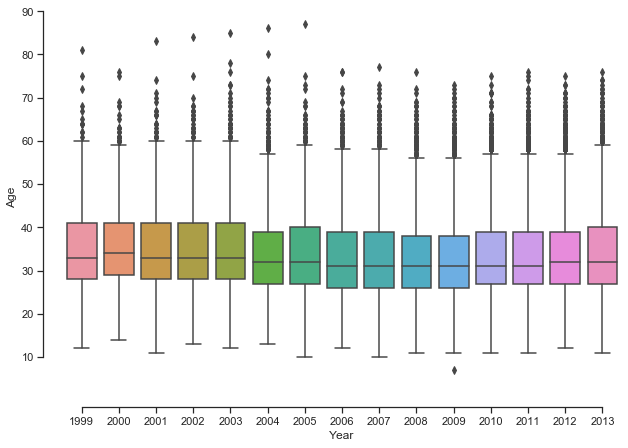

In [6]:
plt.figure(figsize=(10,7))
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="Year", y="Age", data=df1)
sns.despine(offset=20, trim=True)

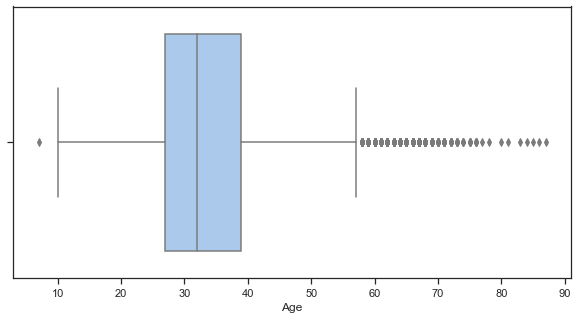

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["Age"])

Text(0.5, 1.0, 'Age Distribution')

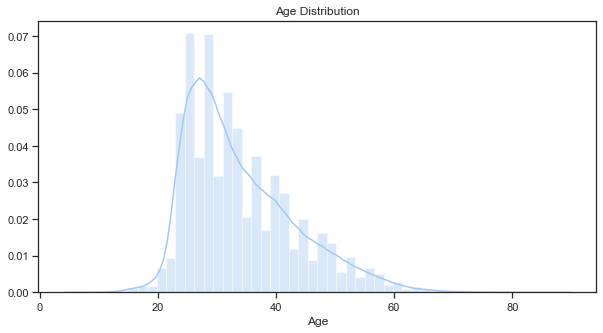

In [8]:
plt.figure(figsize=(10,5))
sns.distplot(df1['Age'])
plt.title("Age Distribution")

Text(0, 0.5, 'Runners')

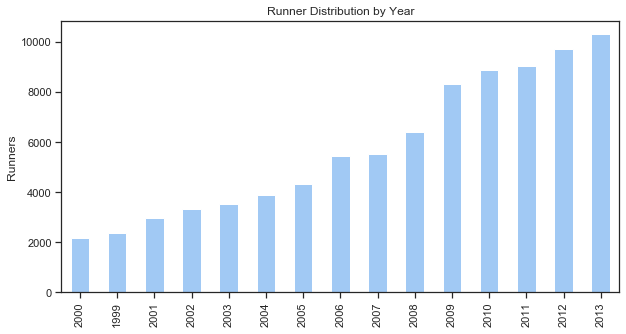

In [10]:
df1.Year.value_counts().nsmallest(15).plot(kind='bar', figsize=(10,5))
plt.title("Runner Distribution by Year")
plt.ylabel("Runners")

,Year,Age
Year,1.000000,-0.033776
Age,-0.033776,1.000000


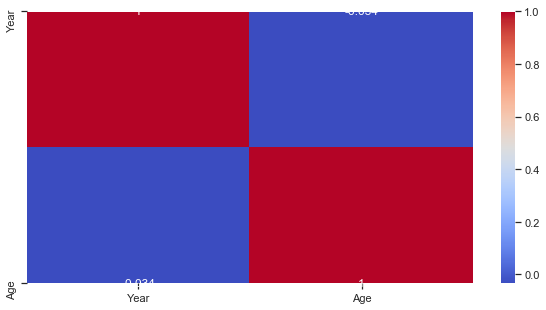

In [14]:
plt.figure(figsize=(10,5))
c= df1.corr()
sns.heatmap(c,cmap='coolwarm',annot=True)
c

In [15]:
df1[["Pace","Time"]].describe()

,Pace,Time
count,86169,86169
unique,651,5199
top,00:09:52,1:36:34
freq,477,62


In [32]:
df1['RunTime'] = [int(a) * 60 + int(b) for a,b,c in df1['Time'].str.split(':')]

In [33]:
df1.head(5)

,Year,Name,Age,Time,Pace,RunTime
0,1999,Jane Omoro (W),26,0:53:37,00:05:22,53
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22,53
2,1999,Eunice Sagero (W),20,0:53:55,00:05:24,53
3,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25,54
4,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25,54


Text(0, 0.5, 'Run Time (minutes)')

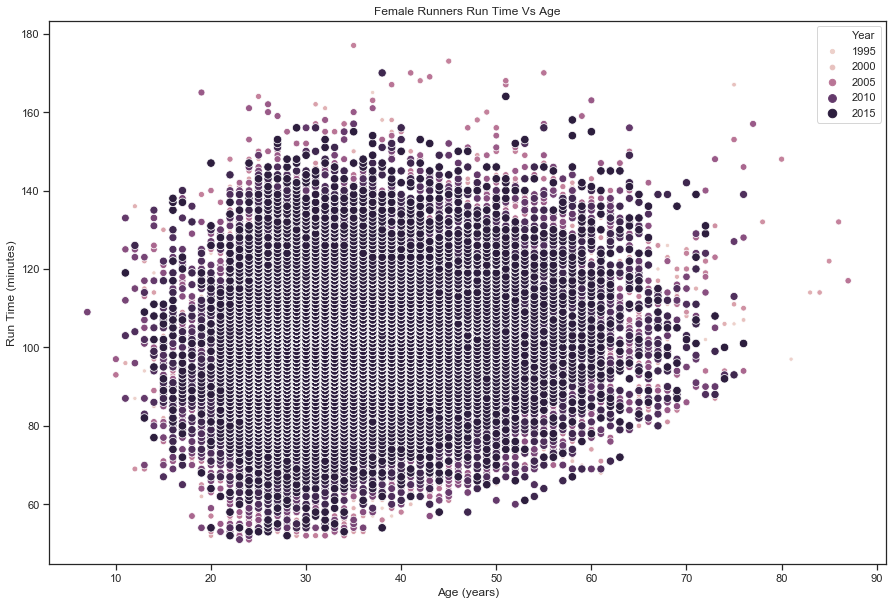

In [37]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.scatterplot(x="Age", y="RunTime", size = "Year", hue = "Year", data=df1)
plt.title('Female Runners Run Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Run Time (minutes)')


Plotting the scatterplot of female runners' run-time per age clearly shows an increase in run-time as age increases. However, it is difficult to see any details on trend due to many points crowded on top of each other. We can see that we have a female runner with less than 10 years of age. 

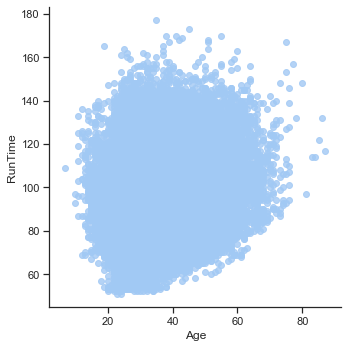

In [41]:
sns.lmplot(x='Age', y='RunTime', data=df1, fit_reg=False);

By applying KDE to smooth the plot.

Text(0, 0.5, 'RunTime (minutes)')

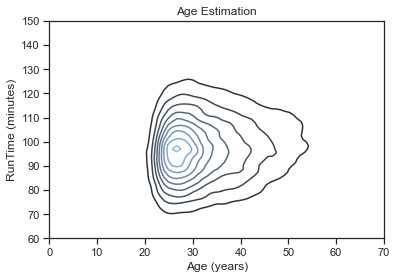

In [47]:
sns.kdeplot(df1['Age'], df1['RunTime'])
plt.xlim(0, 70)
plt.ylim(60, 150);
plt.title('Age Estimation')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('RunTime (minutes)')

Clearly we can see that majority of female runners age is between 20 and 60. Therefore, investigation require into our dataset for runners age is between 0 and 10.

In [60]:
bins = [0, 10, 20, 30, 40, 50, 60, 70]
names = ['0-15', '16-25', '26-40', '41-50','51-60', '61-70','71+']

df1['AgeRange'] = pd.cut(df1['Age'], bins, labels=names)


In [61]:
df1.head(5)

,Year,Name,Age,Time,Pace,RunTime,AgeRange
0,1999,Jane Omoro (W),26,0:53:37,00:05:22,53,26-40
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22,53,26-40
2,1999,Eunice Sagero (W),20,0:53:55,00:05:24,53,16-25
3,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25,54,26-40
4,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25,54,26-40


Text(0, 0.5, 'Frequency')

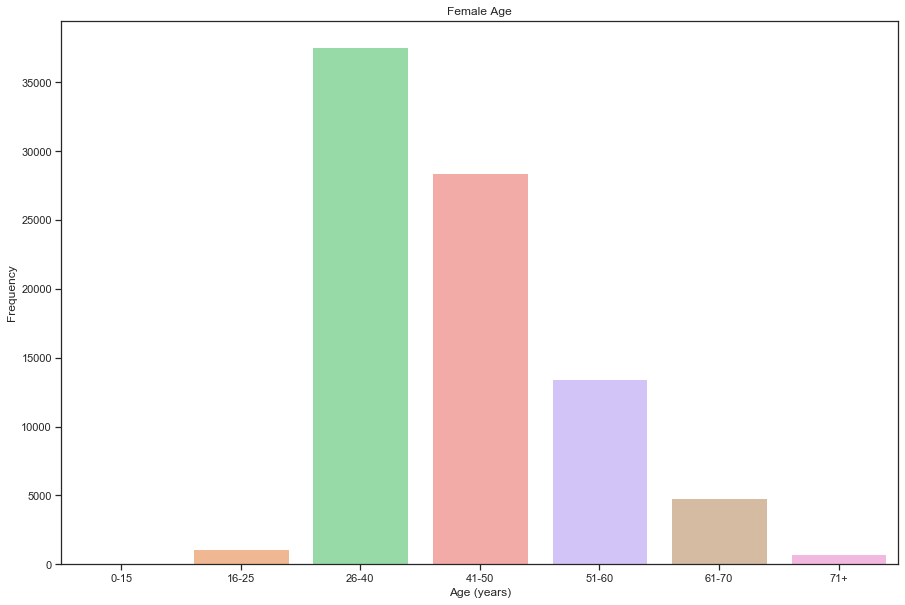

In [62]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.countplot('AgeRange', data=df1)
plt.title('Female Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Frequency')


Text(0, 0.5, 'Run Time (minutes)')

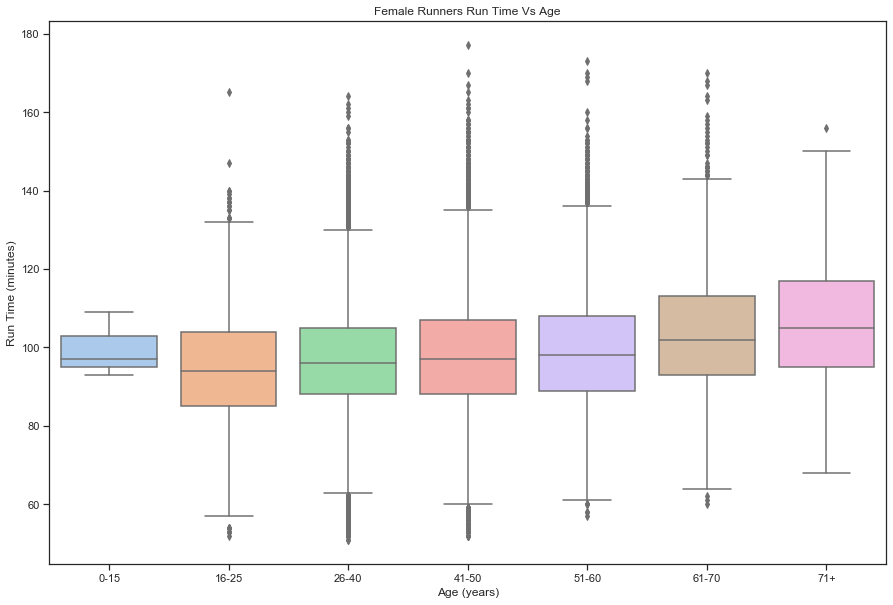

In [63]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="AgeRange", y="RunTime", data=df1)
plt.title('Female Runners Run Time Vs Age Range')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Run Time (minutes)')

In [64]:
df1['PaceTime'] = [int(a) * 60 + int(b)* 60 + int(c) for a,b,c in df1['Pace'].str.split(':')]

In [65]:
df1.head(5)

,Year,Name,Age,Time,Pace,RunTime,AgeRange,PaceTime
0,1999,Jane Omoro (W),26,0:53:37,00:05:22,53,26-40,322
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22,53,26-40,322
2,1999,Eunice Sagero (W),20,0:53:55,00:05:24,53,16-25,324
3,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25,54,26-40,325
4,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25,54,26-40,325


Text(0, 0.5, 'Pace Time (Seconds)')

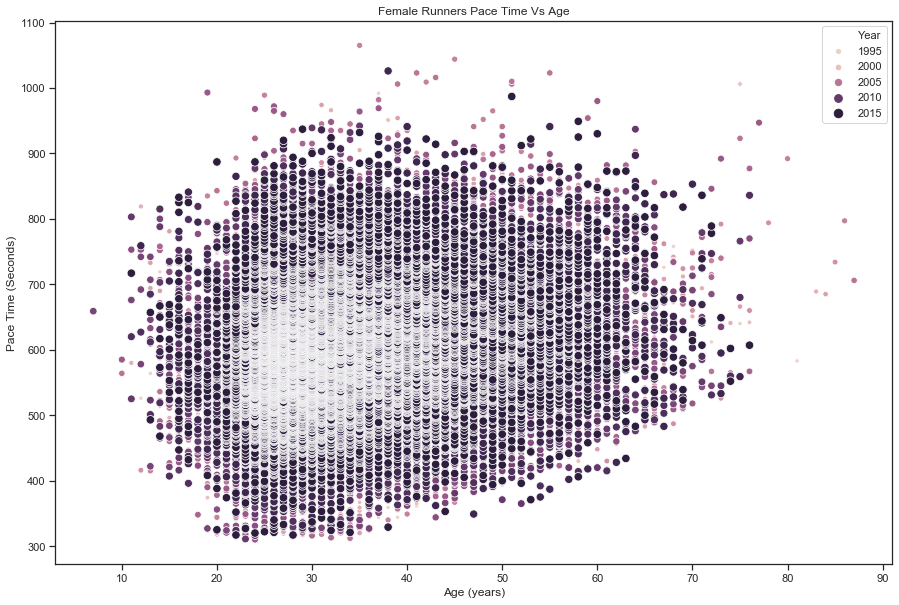

In [71]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.scatterplot(x="Age", y="PaceTime", size = "Year", hue = "Year", data=df1)
plt.title('Female Runners Pace Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Pace Time (Seconds)')

Text(0, 0.5, 'PaceTime (seconds)')

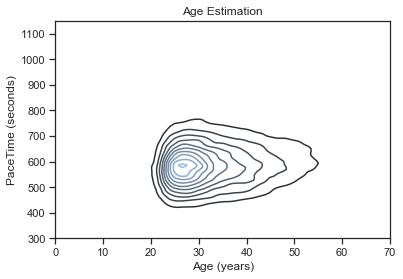

In [68]:
sns.kdeplot(df1['Age'], df1['PaceTime'])
plt.xlim(0, 70)
plt.ylim(300, 1150);
plt.title('Age Estimation')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('PaceTime (seconds)')

Text(0, 0.5, 'Years')

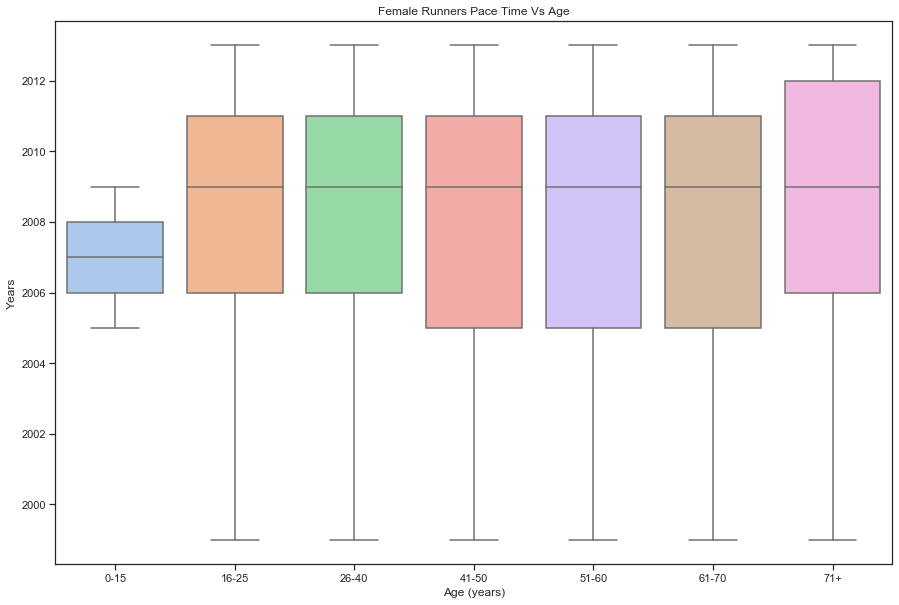

In [96]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="AgeRange", y="Year", data=df1)
plt.title('Female Runners Pace Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Years')

Text(0, 0.5, 'Age (years)')

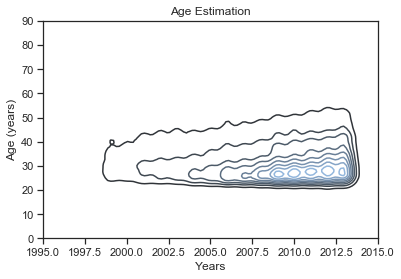

In [101]:
sns.kdeplot(df1['Year'], df1['Age'])
plt.ylim(0, 90)
plt.xlim(1995, 2015);
plt.title('Age Estimation')
# Set x-axis label
plt.xlabel('Years')
# Set y-axis label
plt.ylabel('Age (years)')

Text(0, 0.5, 'Pace Time (seconds)')

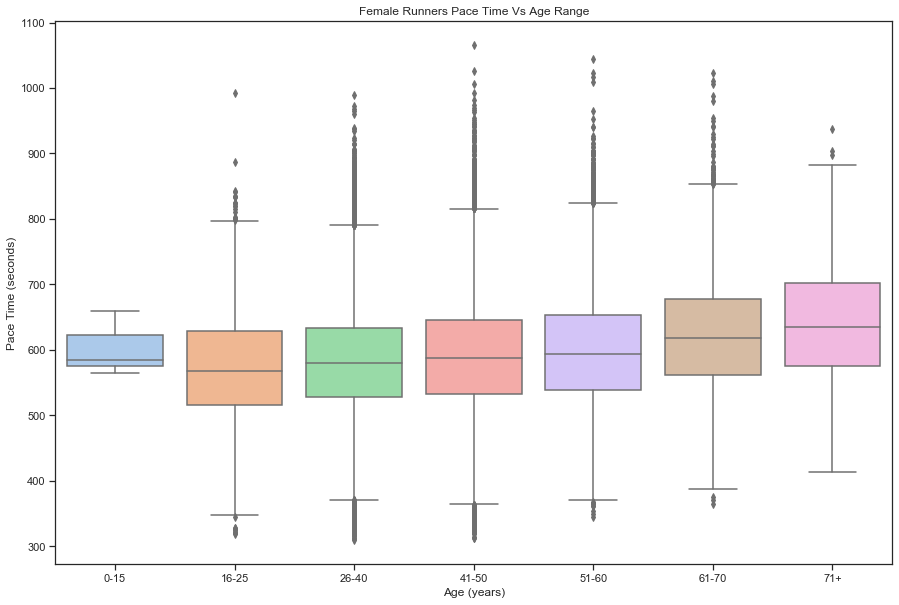

In [69]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="AgeRange", y="PaceTime", data=df1)
plt.title('Female Runners Pace Time Vs Age Range')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Pace Time (seconds)')

Text(0, 0.5, 'Run Time (minutes)')

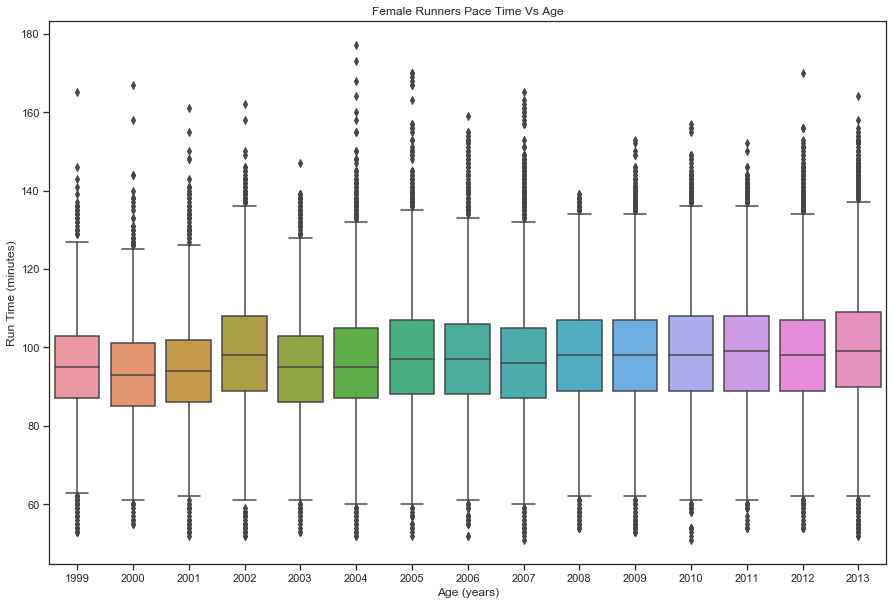

In [85]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="Year", y="RunTime",  data=df1)
plt.title('Female Runners Pace Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Run Time (minutes)')

Text(0.5, 0, 'Run Time (minutes)')

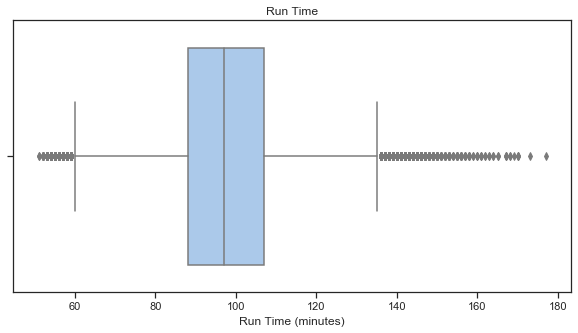

In [90]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["RunTime"])
plt.title('Run Time')
# Set x-axis label
plt.xlabel('Run Time (minutes)')

Text(0.5, 0, 'Age (years)')

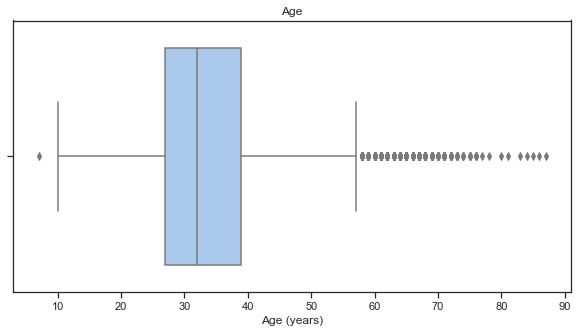

In [91]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["Age"])
plt.title('Age')
# Set x-axis label
plt.xlabel('Age (years)')